In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
# inline plotting
%matplotlib inline

In [2]:
from labproject.experiments import Experiment, ScaleDim, ScaleSampleSize
from labproject.utils import get_log_path

/home/auguste/work/projects/labproject/labproject/plotting.py:13: UserWarning: Style includes a parameter, 'figure.max_open_warning', that is not related to style.  Ignoring this parameter.
  plt.style.use(STYLE_PATH)


In [3]:
from labproject.data import DATASETS, DISTRIBUTIONS
from torch.distributions import MultivariateNormal


In [4]:
col_inter = {
    "SW" : "C0",
    "MMD": "C1",
    "KL": "C2",
    "C2ST": "C3",
    "FID": "C4",
}

col_intra = {
    "SW": "midnightblue",
    "MMD": "brown",
    "KL": "olive",
    "C2ST": "maroon",
    "FID": "purple",
}

col_dict= {0: col_inter, 1: col_intra}
# make a mapping from the experiment name to the color
mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
           'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
           'ScaleSampleSizeFID':'FID'}

Running experiments...
Seed: 0
Experiments: ['ScaleSampleSizeKL', 'ScaleSampleSizeSW']
Data: toy_2d
det intra tensor(7.1835) det gt tensor(7.0532) det inter tensor(7.1759)
[3, 103, 203, 303, 403, 503, 603, 703, 803, 903, 1003, 1103, 1203, 1303, 1403, 1503, 1603, 1703, 1803, 1903]
det intra tensor(7.1835) det gt tensor(7.0532)
Experiment ScaleSampleSizeKL finished in 0.0036749839782714844
Numerical results saved to results/samplesize/samplesize_2024-02-06_11-54-55.pkl
Plots saved to toy_2d.png
det intra tensor(7.1759) det gt tensor(7.0532)
Experiment ScaleSampleSizeKL finished in 0.006551265716552734
Numerical results saved to results/samplesize/samplesize_2024-02-06_11-54-55.pkl
Plots saved to toy_2d.png
[3, 103, 203, 303, 403, 503, 603, 703, 803, 903, 1003, 1103, 1203, 1303, 1403, 1503, 1603, 1703, 1803, 1903]
det intra tensor(7.1835) det gt tensor(7.0532)
Experiment ScaleSampleSizeSW finished in 0.011761903762817383
Numerical results saved to results/samplesize/samplesize_2024-02-06_

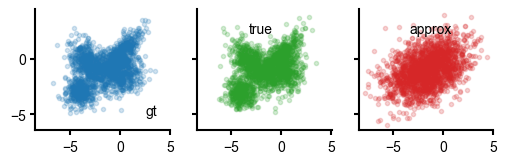

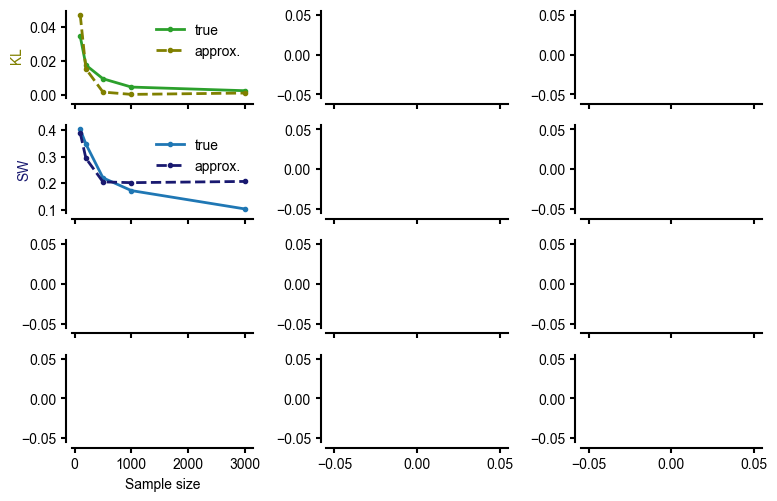

In [12]:
from labproject.data import DATASETS, DISTRIBUTIONS
from labproject.utils import get_cfg, set_seed, get_log_path
from labproject.data import get_dataset
import os
from omegaconf import OmegaConf
from labproject.experiments import ScaleDim, ScaleDimKL, ScaleDimSW, ScaleSampleSizeKL, ScaleSampleSizeSW
from labproject.plotting import cm2inch
import time
import datetime
import pickle
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal


print("Running experiments...")
# load the config file
cfg = OmegaConf.load("configs/conf_samplesize.yaml") 
cfg.running_user = 'samplesize'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")

dataset_fn = get_dataset(cfg.data)
n_samples = 2000



dataset_gt = dataset_fn(n_samples,2)
dataset_intra = dataset_fn(n_samples,2)
dataset_inter = MultivariateNormal(torch.mean(dataset_gt, axis=0).T,
                                   torch.cov(dataset_gt.T)).sample((n_samples,))
print('det intra', torch.det(torch.cov(dataset_intra.T)), 'det gt', torch.det(torch.cov(dataset_gt.T)), 'det inter', torch.det(torch.cov(dataset_inter.T)))
fig, axes = plt.subplots(1, 3, figsize=cm2inch((15, 4)), sharex=True, sharey=True)

axes[0].plot(dataset_gt[:, 0], dataset_gt[:, 1], 'o', label='gt', alpha=0.2, color='C0')
axes[1].plot(dataset_intra[:, 0], dataset_intra[:, 1], 'o', label='true',  alpha=0.2, color='C2')
axes[2].plot(dataset_inter[:, 0], dataset_inter[:, 1], 'o', label='approx' ,alpha=0.2, color='C3')
for ax in axes:
    ax.legend()

# make comparison plots
fig, axes = plt.subplots(4, 3, figsize=cm2inch((20, 13)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=4)


for e, exp_name in enumerate(cfg.experiments):
    experiment = globals()[exp_name]()
    time_start = time.time()
    dataset1 = dataset_gt
    ax = axes[e,0]
    for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
        dataset2 = data_comp
        print('det intra', torch.det(torch.cov(dataset2.T)), 'det gt', torch.det(torch.cov(dataset1.T)))


        output = experiment.run_experiment(dataset1=dataset1,
                                           dataset2=dataset2,
                                           sample_sizes=[100,200,500,1000, 3000])#np.insert(np.logspace(1, 3, 10, dtype=int), 0, 3))
        time_end = time.time()
        print(f"Experiment {exp_name} finished in {time_end - time_start}")

        log_path = get_log_path(cfg)
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        experiment.log_results(output, log_path)
        print(f"Numerical results saved to {log_path}")

        
        experiment.plot_experiment(*output, cfg.data,
                                   ax=ax,
                                   color=col_dict[dc][mapping[exp_name]], 
                                   label='true' if dc == 0 else 'approx.',
                                   linestyle='-' if dc == 0 else '--',lw=2, marker='o')
        ax.set_ylabel(mapping[exp_name])
        ax.set_xlabel('')
        
        print(f"Plots saved to {cfg.data}.png")
    ax.legend()
    
axes[-1,0].set_xlabel('Sample size')
plt.tight_layout()
plt.savefig(f"plots/{cfg.data}.png", dpi=300)
print("Finished running experiments.")
